# Simplified detection of urban types

Example adapted from the [SDSC 2021 Workshop](https://github.com/martinfleis/sdsc21-workshop) led by Martin Fleischmann. You can see the recording of the workshop on [YouTube](https://www.youtube.com/watch?v=itUX56Ks1UE).

This example illustrates the potential of morphometrics captured by `momepy` in capturing the structure of cities. We will pick a town, fetch its data from the OpenStreetMap, and analyse it to detect individual types of urban structure within it.

This method is only illustrative and is based on the more extensive one published by Fleischmann et al. (2021) available from [https://github.com/martinfleis/numerical-taxonomy-paper](https://github.com/martinfleis/numerical-taxonomy-paper).

> Fleischmann M, Feliciotti A, Romice O and Porta S (2021) Methodological Foundation of a Numerical Taxonomy of Urban Form. Environment and Planning B: Urban Analytics and City Science, doi: 10.1177/23998083211059835

It depends on the following packages:

```
- momepy
- osmnx
- clustergram
- bokeh
- scikit-learn
- geopy
- ipywidgets
```


In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

/Users/martin/miniforge3/envs/pysal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Znojmo, Czechia'
local_crs = 5514

We can interactively explore the place we just selected.

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

We can use ``OSMnx`` to quickly download data from OpenStreetMap. If you intend to download larger areas, we recommend using ``pyrosm`` instead.

### Buildings

In [4]:
buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})
buildings.head()

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_81241/1465348557.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})


power                   geometry amenity brand  \
element_type osmid                                                       
node         3372076291   NaN  POINT (16.05376 48.84683)     NaN   NaN   
             3372076393   NaN  POINT (16.05581 48.84158)     NaN   NaN   
             3372076394   NaN  POINT (16.05867 48.83522)     NaN   NaN   
             3372076428   NaN  POINT (16.03949 48.85599)     NaN   NaN   
             3372076429   NaN  POINT (16.04133 48.85501)     NaN   NaN   

                        brand:wikidata brand:wikipedia check_date  \
element_type osmid                                                  
node         3372076291            NaN             NaN        NaN   
             3372076393            NaN             NaN        NaN   
             3372076394            NaN             NaN        NaN   
             3372076428            NaN             NaN        NaN   
             3372076429            NaN             NaN        NaN   

                                   name operator operator:wikidata  ...  \
element_type osmid                                                  ...   
node         3372076291    7/I/10/A-120      NaN               NaN  ...   
             3372076393  7/I/11/A-140 Z      NaN               NaN  ...   
             3372076394    7/I/12/A-220      NaN               NaN  ...   
             3372076428         7/I/8/E      NaN               NaN  ...   
             3372076429         7/I/9/E      NaN               NaN  ...   

                        material name:signed  ref monitoring:water_level  \
element_type osmid                                                         
node         3372076291      NaN         NaN  NaN                    NaN   
             3372076393      NaN         NaN  NaN                    NaN   
             3372076394      NaN         NaN  NaN                    NaN   
             3372076428      NaN         NaN  NaN                    NaN   
             3372076429      NaN         NaN  NaN                    NaN   

                        takeaway shelter_type construction ways type emergency  
element_type osmid                                                              
node         3372076291      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076393      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076394      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076428      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076429      NaN          NaN          NaN  NaN  NaN       NaN  

[5 rows x 119 columns]

The OSM input may need a bit of cleaning to ensure only proper polygons are kept.

In [5]:
buildings.geom_type.value_counts()

Polygon    12214
Point          7
Name: count, dtype: int64

In [6]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

And we should re-project the data from WGS84 to the local projection in meters (momepy default values assume meters not feet or degrees). We will also drop unnecessary columns.

In [7]:
buildings = buildings[["geometry"]].to_crs(local_crs)

Finally, we can assign unique ID to each row.

In [8]:
buildings["uID"] = range(len(buildings))
buildings.head()

geometry  uID
0  POLYGON ((-643743.474 -1193358.749, -643743.30...    0
1  POLYGON ((-643751.446 -1193530.633, -643749.37...    1
2  POLYGON ((-643281.601 -1193130.831, -643283.76...    2
3  POLYGON ((-643381.904 -1193174.697, -643388.48...    3
4  POLYGON ((-643370.450 -1193130.215, -643398.26...    4

### Streets

Similar operations are done with streets.

In [9]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)

In [10]:
streets.head()

osmid  ref        name      highway maxspeed  \
u         v          key                                                    
74103628  639231391  0    33733060  361  Přímětická    secondary       50   
          3775990798 0    33733060  361  Přímětická    secondary       50   
639231391 74103628   0    33733060  361  Přímětická    secondary       50   
          74142638   0    33733060  361  Přímětická    secondary       50   
          639231314  0    50313241  NaN  Mičurinova  residential      NaN   

                          oneway reversed   length  \
u         v          key                             
74103628  639231391  0     False    False   24.574   
          3775990798 0     False     True   60.354   
639231391 74103628   0     False     True   24.574   
          74142638   0     False    False   54.260   
          639231314  0      True    False  101.376   

                                                                   geometry  \
u         v          key                                                      
74103628  639231391  0    LINESTRING (-643239.057 -1192850.232, -643229....   
          3775990798 0    LINESTRING (-643239.057 -1192850.232, -643241....   
639231391 74103628   0    LINESTRING (-643229.639 -1192872.949, -643239....   
          74142638   0    LINESTRING (-643229.639 -1192872.949, -643219....   
          639231314  0    LINESTRING (-643229.639 -1192872.949, -643233....   

                         lanes bridge junction width tunnel access  
u         v          key                                            
74103628  639231391  0     NaN    NaN      NaN   NaN    NaN    NaN  
          3775990798 0     NaN    NaN      NaN   NaN    NaN    NaN  
639231391 74103628   0     NaN    NaN      NaN   NaN    NaN    NaN  
          74142638   0     NaN    NaN      NaN   NaN    NaN    NaN  
          639231314  0     NaN    NaN      NaN   NaN    NaN    NaN

We can also do some preprocessing using momepy to ensure we have proper network topology.

In [11]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

/Users/martin/miniforge3/envs/pysal/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as S-JTSK / Krovak East North (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [12]:
streets.head()

geometry  nID
0  LINESTRING (-643239.057 -1192850.232, -643229....    0
1  LINESTRING (-643239.057 -1192850.232, -643241....    1
2  LINESTRING (-643229.639 -1192872.949, -643239....    2
3  LINESTRING (-643229.639 -1192872.949, -643219....    3
4  LINESTRING (-643229.639 -1192872.949, -643233....    4

## Generated data

### Tessellation

Given building footprints:

![blg](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_3_0.png)

We can generate a spatial unit using morphological tessellation:

![tess](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_14_0.png)

In [13]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_81241/1328706492.py:3: UserWarning: Tessellation does not fully match buildings. 20 element(s) collapsed during generation - unique_id: {3968, 4227, 11255, 10686, 10687, 9026, 4177, 11473, 11474, 8534, 11478, 4185, 4188, 10465, 9061, 3958, 4215, 4218, 4222, 4223}.
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_81241/1328706492.py:3: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [4167, 3227, 11783, 3173, 10997].
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)


### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [14]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

geometry  uID  index_right     nID
0  POLYGON ((-643743.474 -1193358.749, -643743.30...    0       1047.0  1047.0
0  POLYGON ((-643743.474 -1193358.749, -643743.30...    0       1048.0  1048.0
1  POLYGON ((-643751.446 -1193530.633, -643749.37...    1       1485.0  1485.0
2  POLYGON ((-643281.601 -1193130.831, -643283.76...    2        243.0   243.0
2  POLYGON ((-643281.601 -1193130.831, -643283.76...    2        887.0   887.0

Clean duplicates and attach the network ID to the tessellation as well.

In [15]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [16]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [17]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

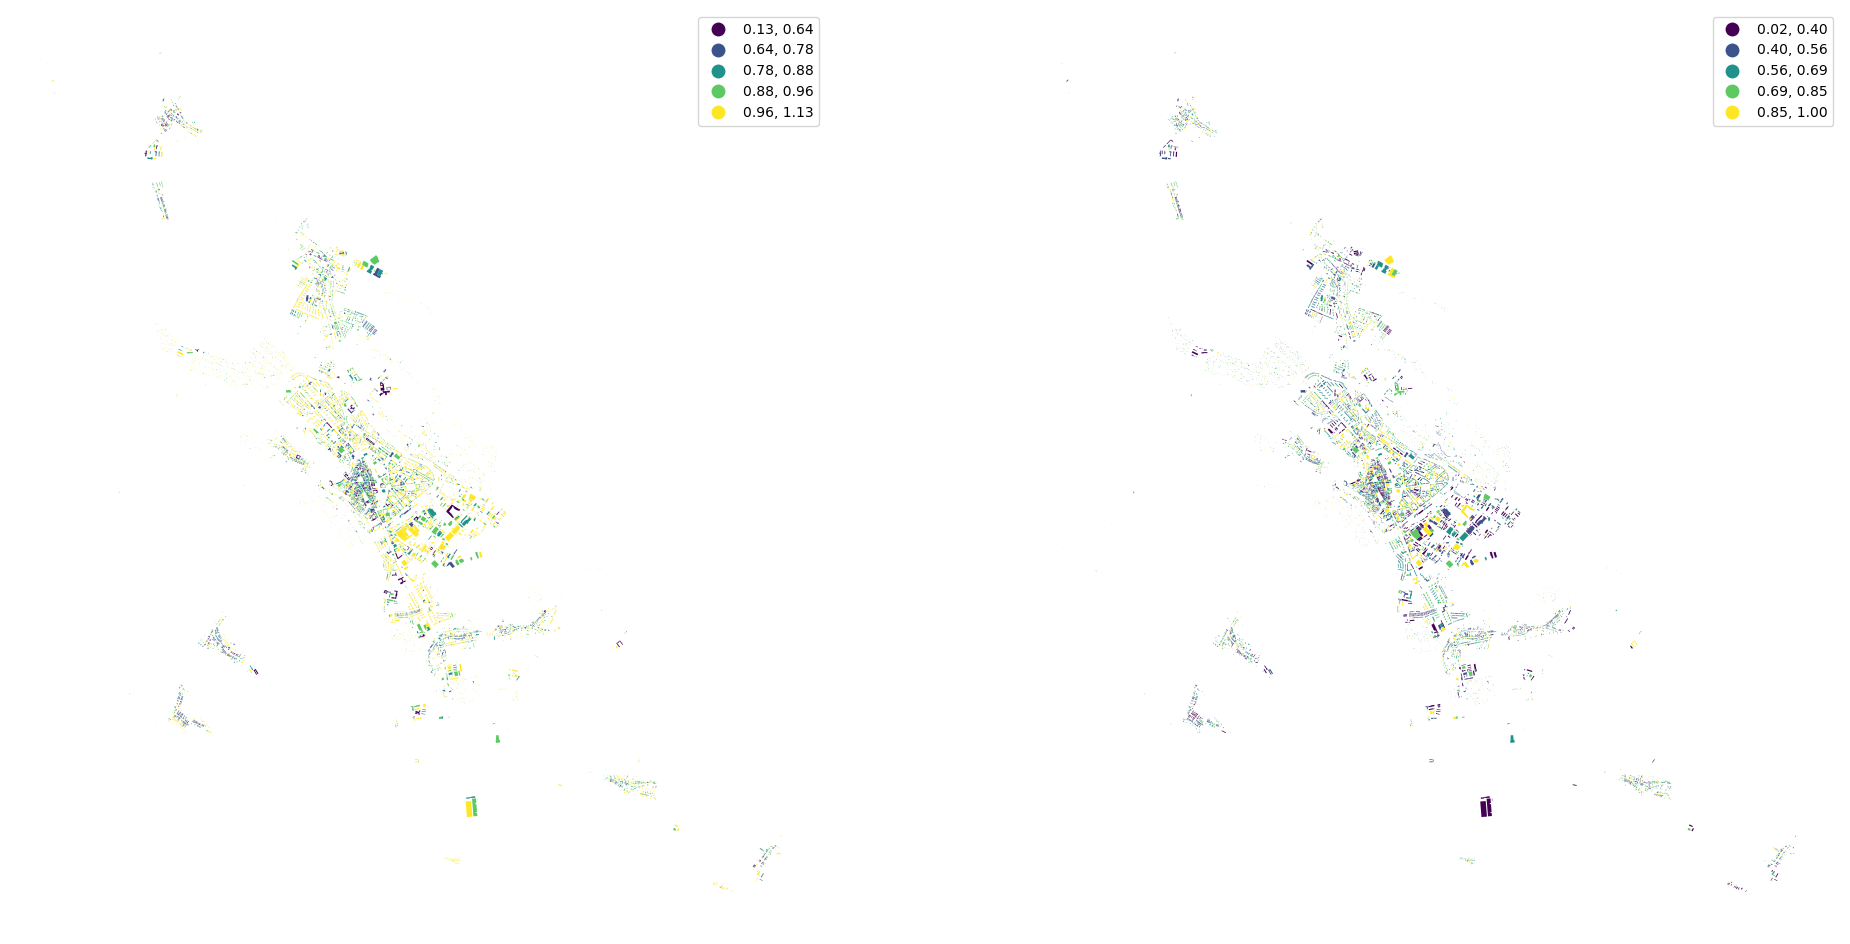

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

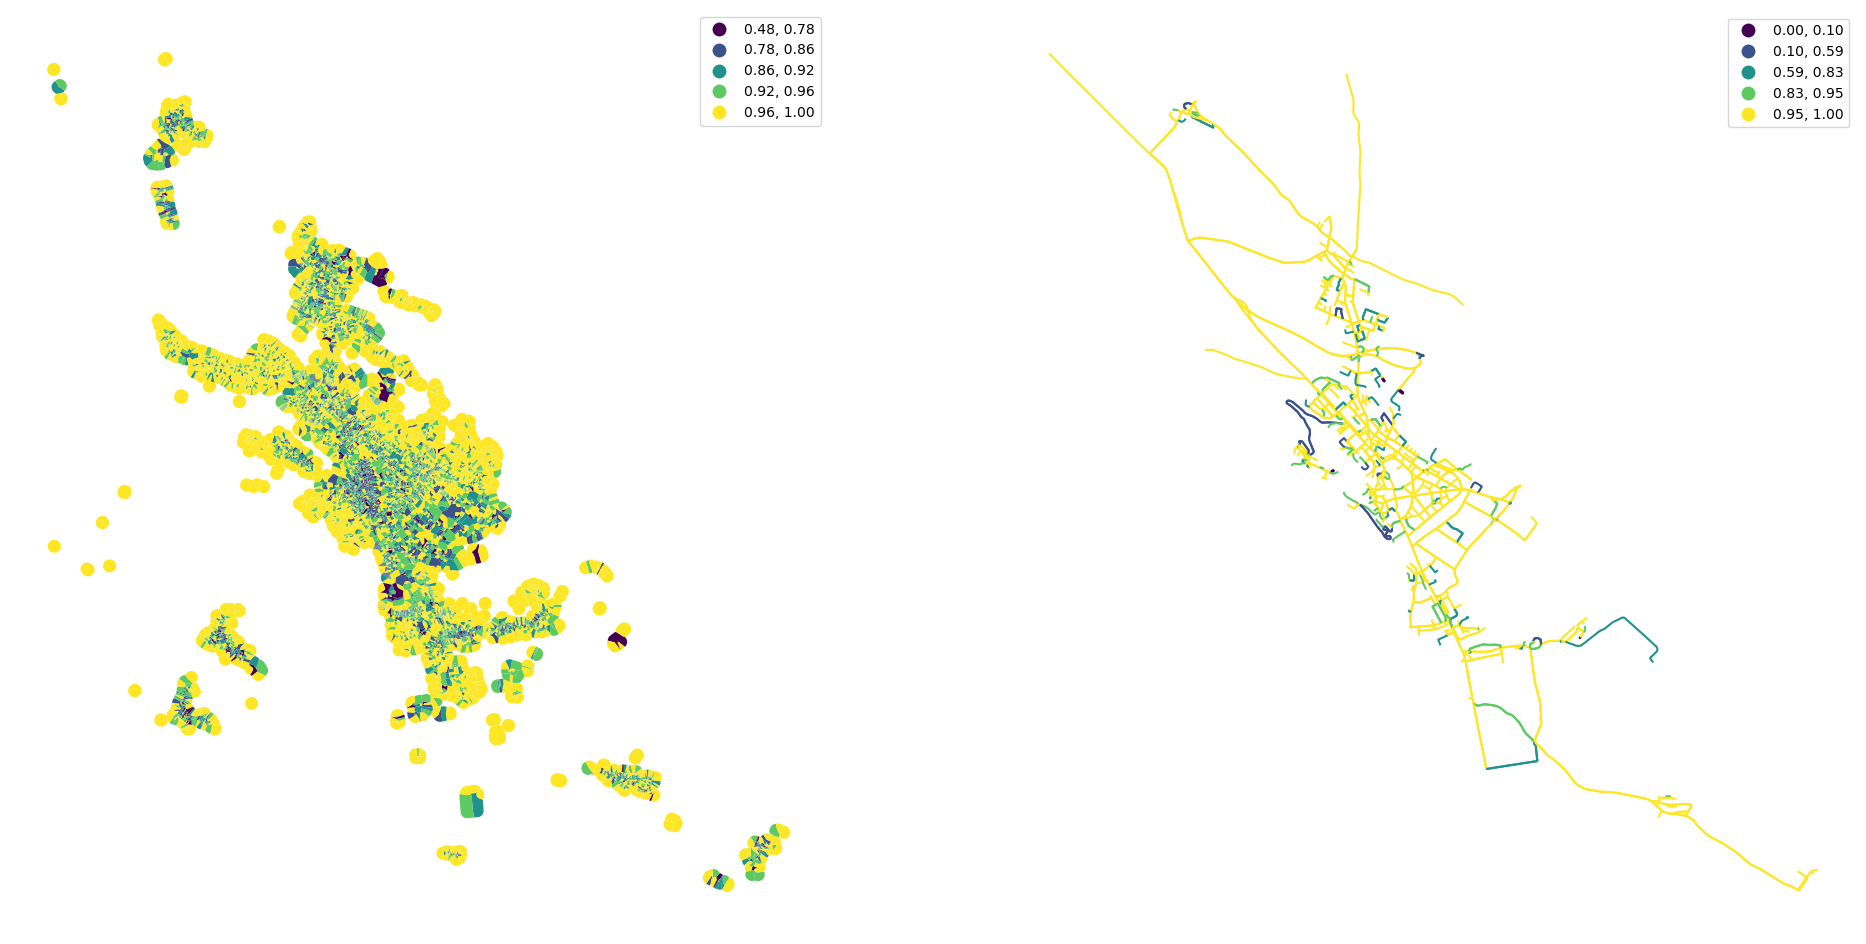

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

/Users/martin/Git/momepy/momepy/distribution.py:137: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")
/Users/martin/miniforge3/envs/pysal/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


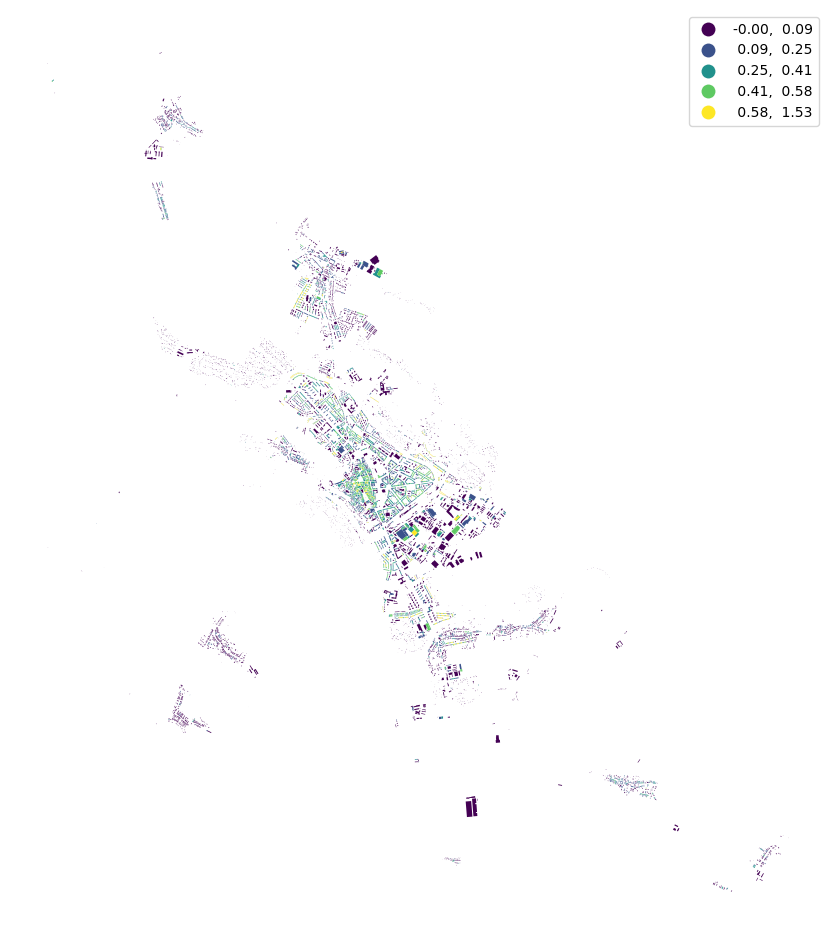

In [20]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

Generate spatial weights matrix using `libpysal`.

In [21]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [22]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

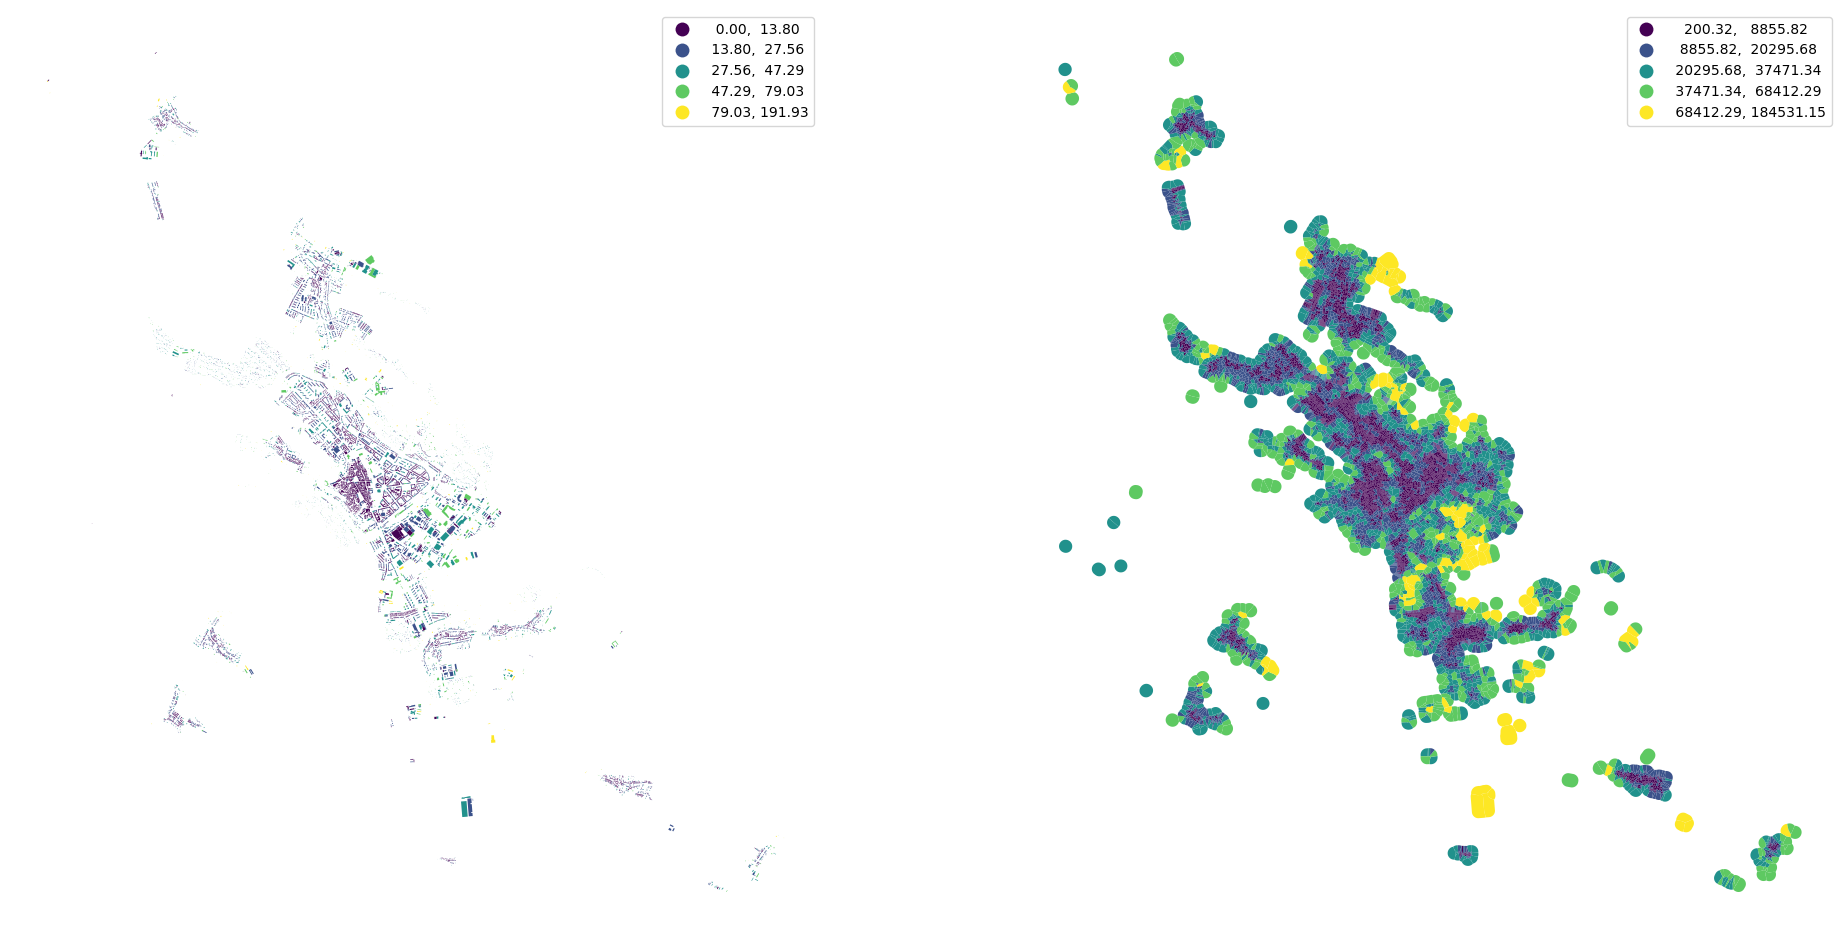

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [24]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', 3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_81241/738459904.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)


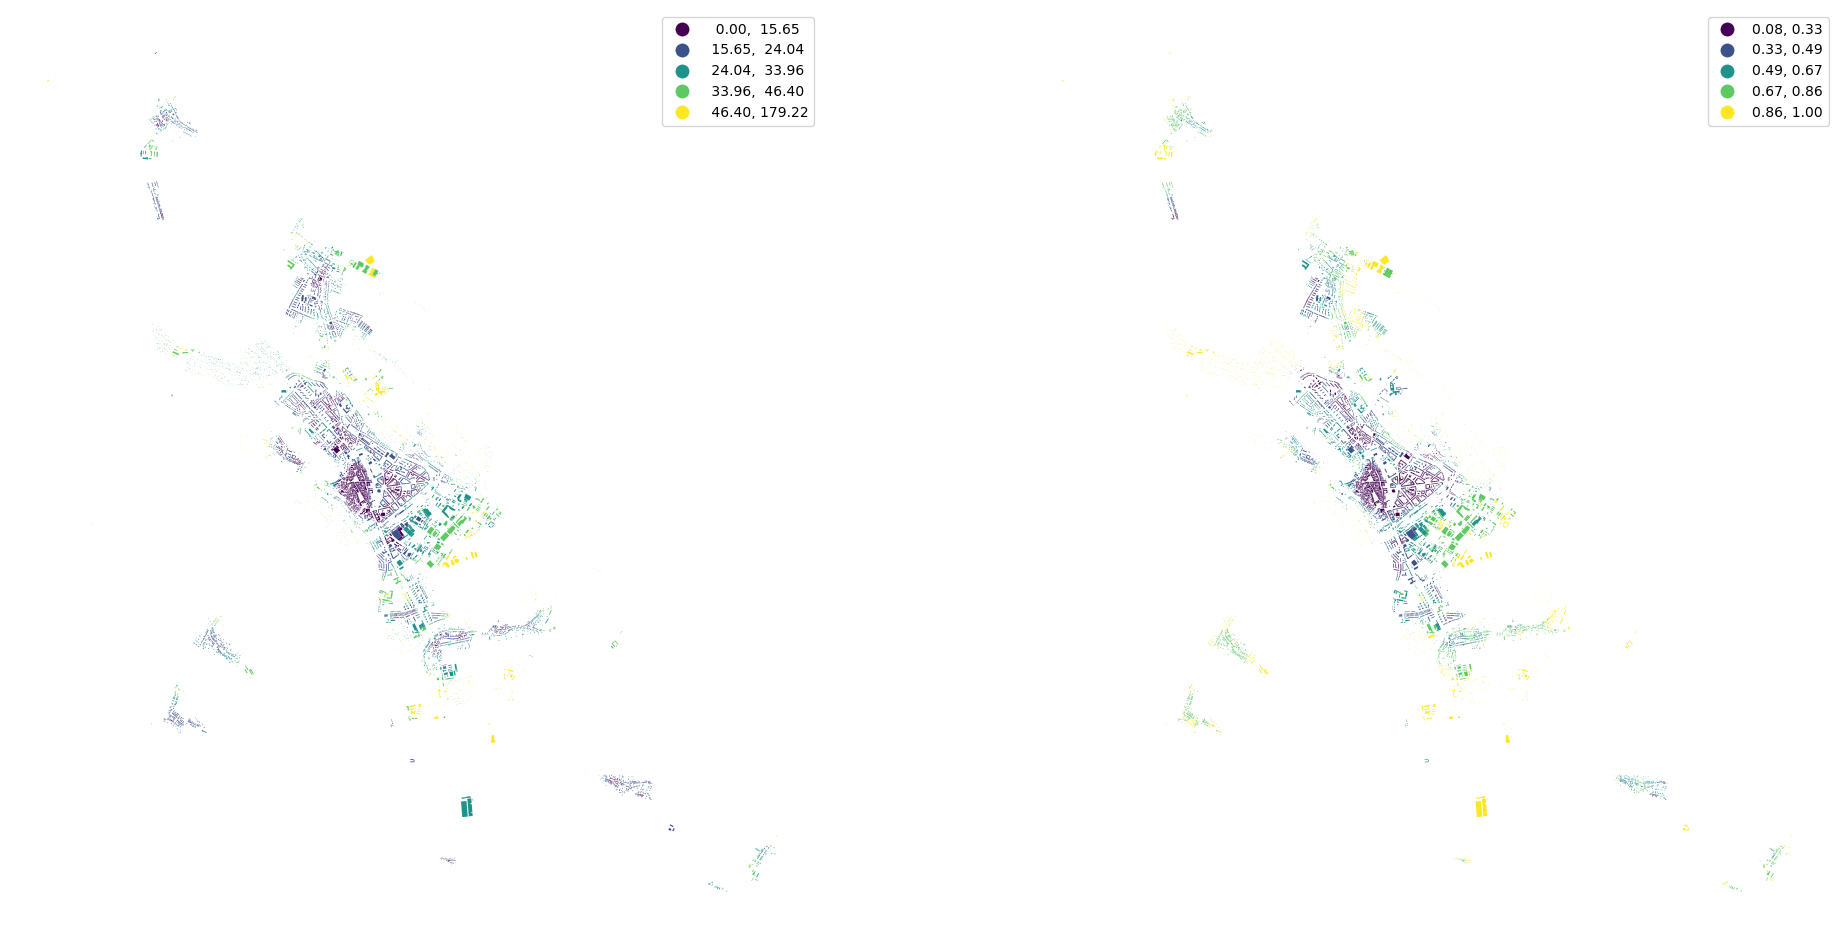

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [26]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

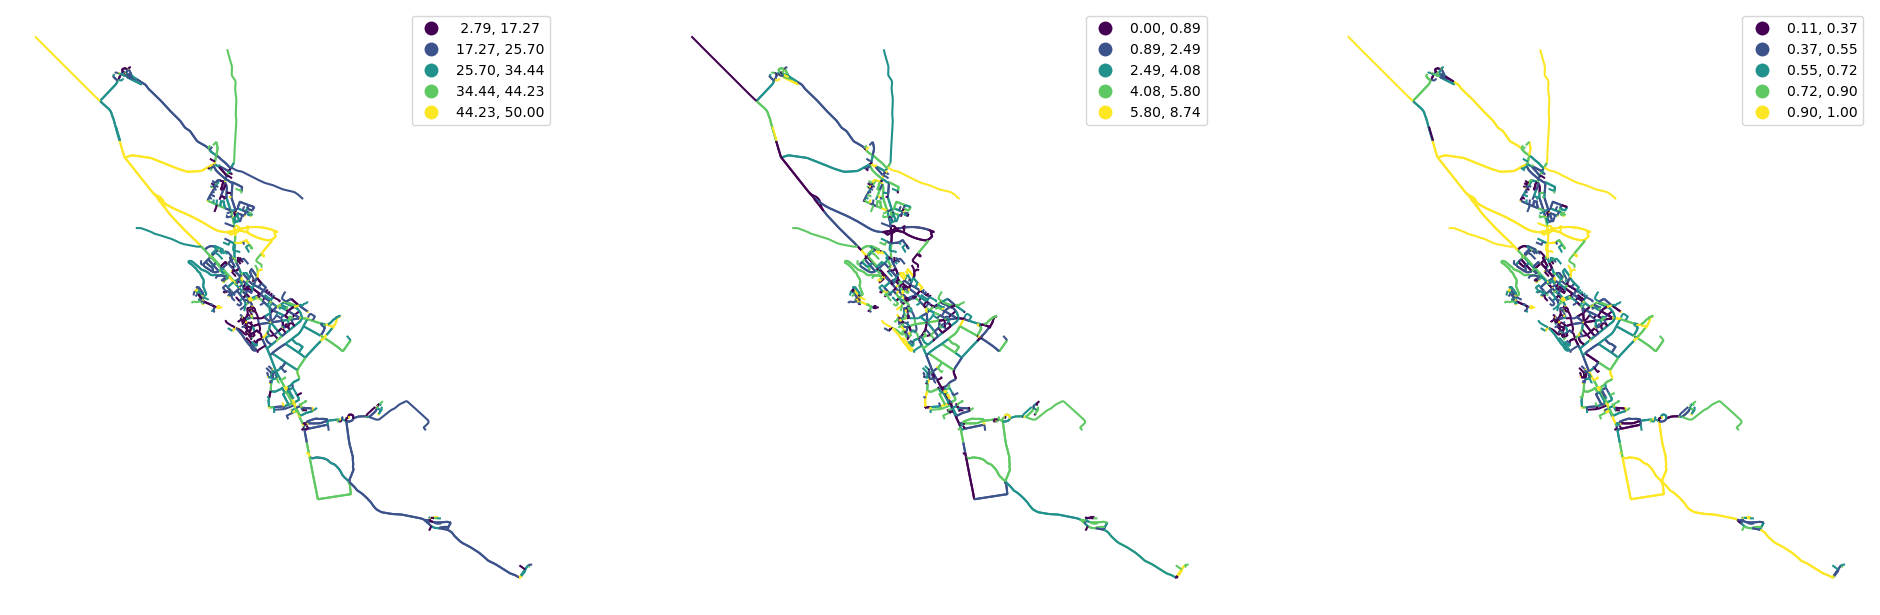

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

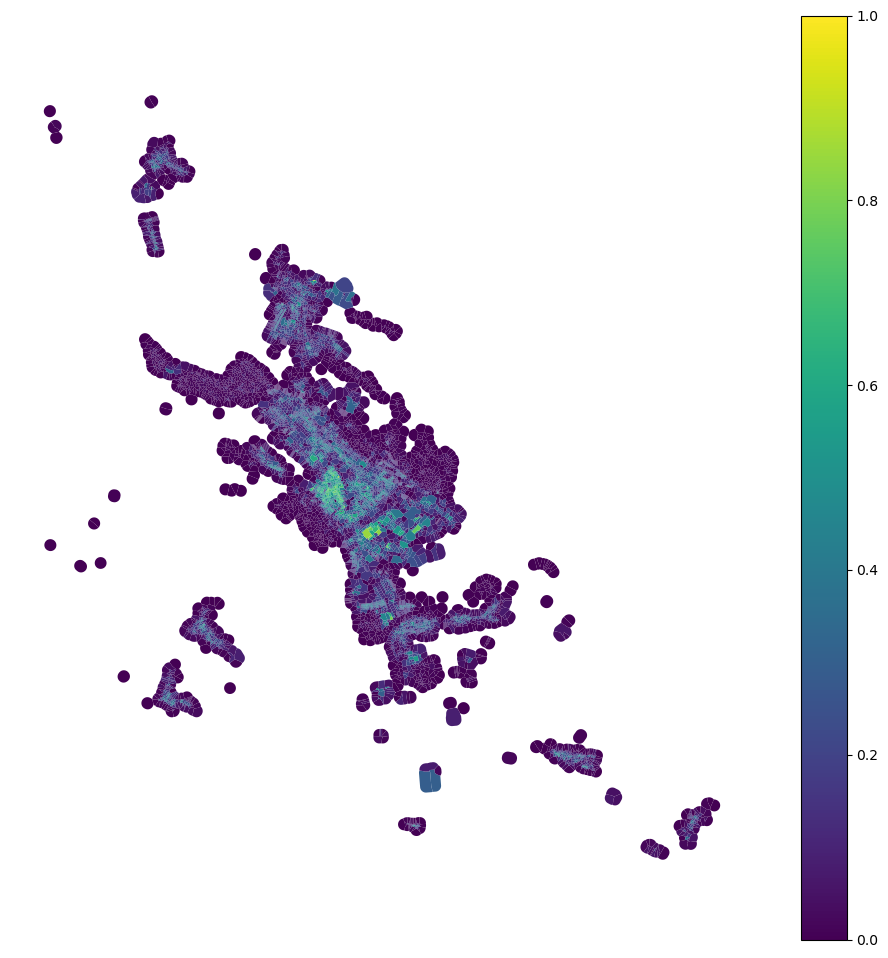

In [28]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

### Connectivity

In [29]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, streets = momepy.nx_to_gdf(graph)

  0%|          | 0/774 [00:00<?, ?it/s]

100%|██████████| 774/774 [00:00<00:00, 2538.13it/s]


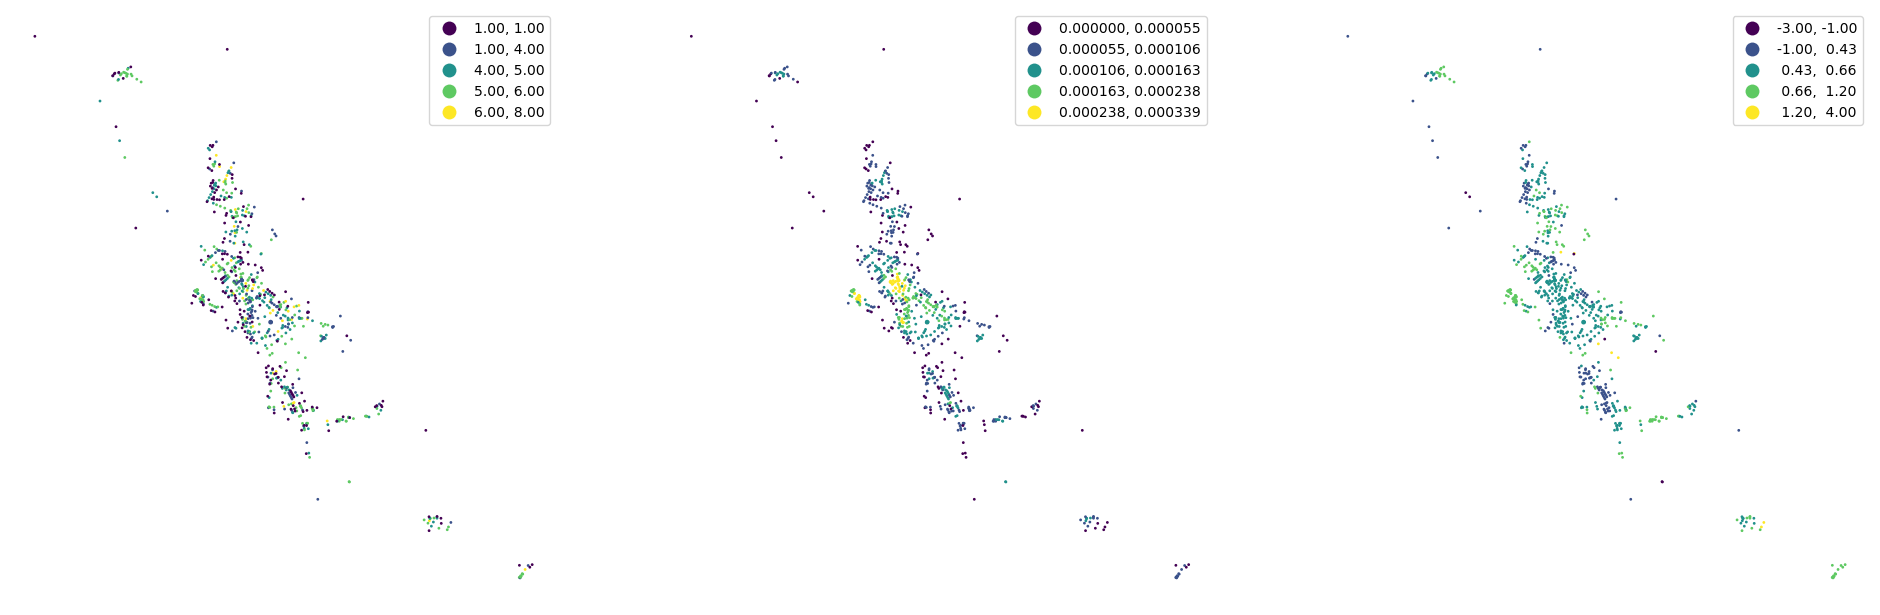

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [31]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

100%|██████████| 12214/12214 [00:00<00:00, 12332.74it/s]


Link all data together (to tessellation cells or buildings).

In [32]:
tessellation.head()

uID                                           geometry     nID  \
0   5329  POLYGON ((-637358.313 -1200006.277, -637357.92...   637.0   
1   5295  POLYGON ((-636869.686 -1199824.120, -636870.16...   647.0   
2  10470  POLYGON ((-637462.192 -1199942.387, -637450.89...   637.0   
3   5328  POLYGON ((-636567.904 -1199437.917, -636567.88...  1636.0   
4  10476  POLYGON ((-637599.665 -1199909.097, -637595.79...   637.0   

           area  convexity  neighbors  covered_area       car  
0  27736.670898   0.995293   0.003108  41793.250296  0.007476  
1  19855.193192   0.942935   0.005466  59301.601010  0.022276  
2   5980.537479   0.900015   0.006719  23484.755027  0.066270  
3  17651.421590   0.989690   0.005897  43087.114344  0.005919  
4   6221.647570   0.829355   0.010157  43342.518118  0.049808

In [33]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [34]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'degree', 'closeness', 'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [35]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

In [36]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

area_x_25    area_x_50    area_x_75  convexity_25  convexity_50  \
0  7151.505439  8460.534527  9102.552267      0.874500      0.888902   
1  2049.363971  4069.346269  7207.822493      0.934390      0.957400   
2  4869.281368  6119.443335  9102.552267      0.874500      0.947803   
3   979.082829  2497.478414  9114.443041      0.945396      0.976589   
4  5615.435877  6119.443335  8460.534527      0.888902      0.947803   

   convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0      0.929755      0.006852      0.007068      0.007307     38509.340859   
1      0.980033      0.015075      0.020266      0.027499     26373.762179   
2      0.971754      0.007068      0.008105      0.009836     28474.090834   
3      0.989613      0.011906      0.027560      0.044586      8894.839436   
4      0.971754      0.007598      0.008616      0.009836     27790.702394   

   ...  openness_75  degree_25  degree_50  degree_75  closeness_25  \
0  ...     0.952261        6.0        6.0        6.0      0.000087   
1  ...     1.000000        4.0        6.0        6.0      0.000094   
2  ...     0.952261        6.0        6.0        6.0      0.000087   
3  ...     0.677778        1.0        4.0        7.0      0.000049   
4  ...     0.952261        6.0        6.0        6.0      0.000087   

   closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0      0.000087      0.000087       0.894737       0.894737       0.894737  
1      0.000094      0.000099       0.809524       0.894737       1.000000  
2      0.000087      0.000087       0.894737       0.894737       0.894737  
3      0.000063      0.000087       0.736842       0.809524       0.809524  
4      0.000087      0.000087       0.894737       0.894737       0.894737  

[5 rows x 60 columns]

See the difference between original convexity and spatially lagged one.

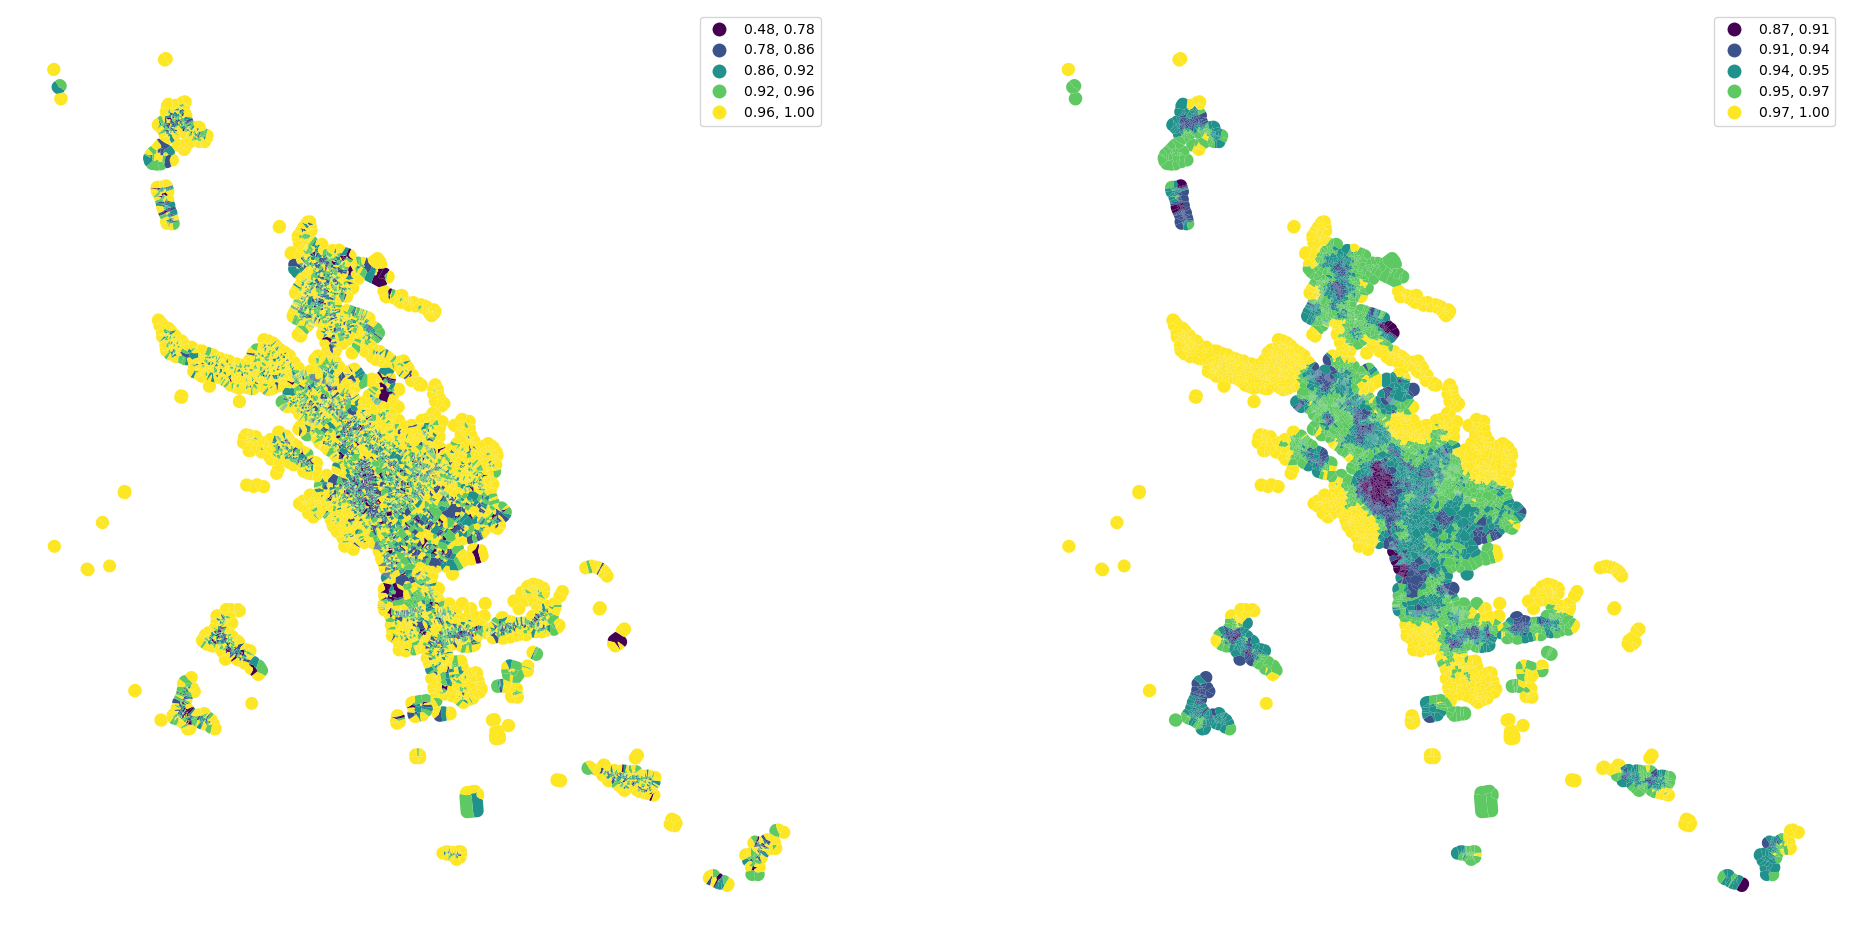

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

Now we can use obtained values within a cluster analysis that should detect types of urban structure.

Standardize values before clustering.

In [38]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()
standardized.head()

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  convexity_75  \
0   3.874598   3.533443   2.323781     -1.155053     -2.962302     -3.777994   
1   0.832751   1.410208   1.680435      0.651102      0.318504      0.394242   
2   2.513958   2.401474   2.323781     -1.155053     -0.141132     -0.292831   
3   0.194660   0.650176   2.327818      0.983041      1.237615      1.189205   
4   2.958808   2.401474   2.105787     -0.720716     -0.141132     -0.292831   

   neighbors_25  neighbors_50  neighbors_75  covered_area_25  ...  \
0     -2.142978     -2.316295     -2.359476         4.382338  ...   
1     -1.533425     -1.566368     -1.503667         2.688808  ...   
2     -2.126994     -2.257388     -2.252308         2.981910  ...   
3     -1.768334     -1.151946     -0.779495         0.249610  ...   
4     -2.087688     -2.228352     -2.252308         2.886543  ...   

   openness_75  degree_25  degree_50  degree_75  closeness_25  closeness_50  \
0     1.567482   1.157891   0.759092   0.405637      0.271975      0.011717   
1     1.810087   0.107411   0.759092   0.405637      0.384216      0.113805   
2     1.567482   1.157891   0.759092   0.405637      0.271975      0.011717   
3     0.172577  -1.468310  -0.372709   1.030416     -0.390730     -0.370683   
4     1.567482   1.157891   0.759092   0.405637      0.271975      0.011717   

   closeness_75  meshedness_25  meshedness_50  meshedness_75  
0     -0.211542       1.432601       1.194016       0.727337  
1     -0.041475       1.114745       1.194016       1.027147  
2     -0.211542       1.432601       1.194016       0.727337  
3     -0.216644       0.843632       0.881838       0.484633  
4     -0.211542       1.432601       1.194016       0.727337  

[5 rows x 60 columns]

### How many clusters?

To determine how many clusters we should aim for, we can use a little package called `clustergram`. See its [documentation](https://clustergram.readthedocs.io) for details.

In [39]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.129 seconds.
K=3 fitted in 0.229 seconds.
K=4 fitted in 0.128 seconds.
K=5 fitted in 0.185 seconds.
K=6 fitted in 0.138 seconds.
K=7 fitted in 0.147 seconds.
K=8 fitted in 0.221 seconds.
K=9 fitted in 0.289 seconds.
K=10 fitted in 0.277 seconds.
K=11 fitted in 0.274 seconds.


Clustegram gives us also the final labels. (Normally, you would run the final clustering on much larger number of initialisations.)

In [40]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   1   0   3   4   1   1   7   6   7   9
1   0   1   0   3   4   1   1   1   6   7   9
2   0   1   0   3   4   1   1   7   6   7   9
3   0   1   0   0   1   2   5   1   3   4   6
4   0   1   0   3   4   1   1   7   6   7   9

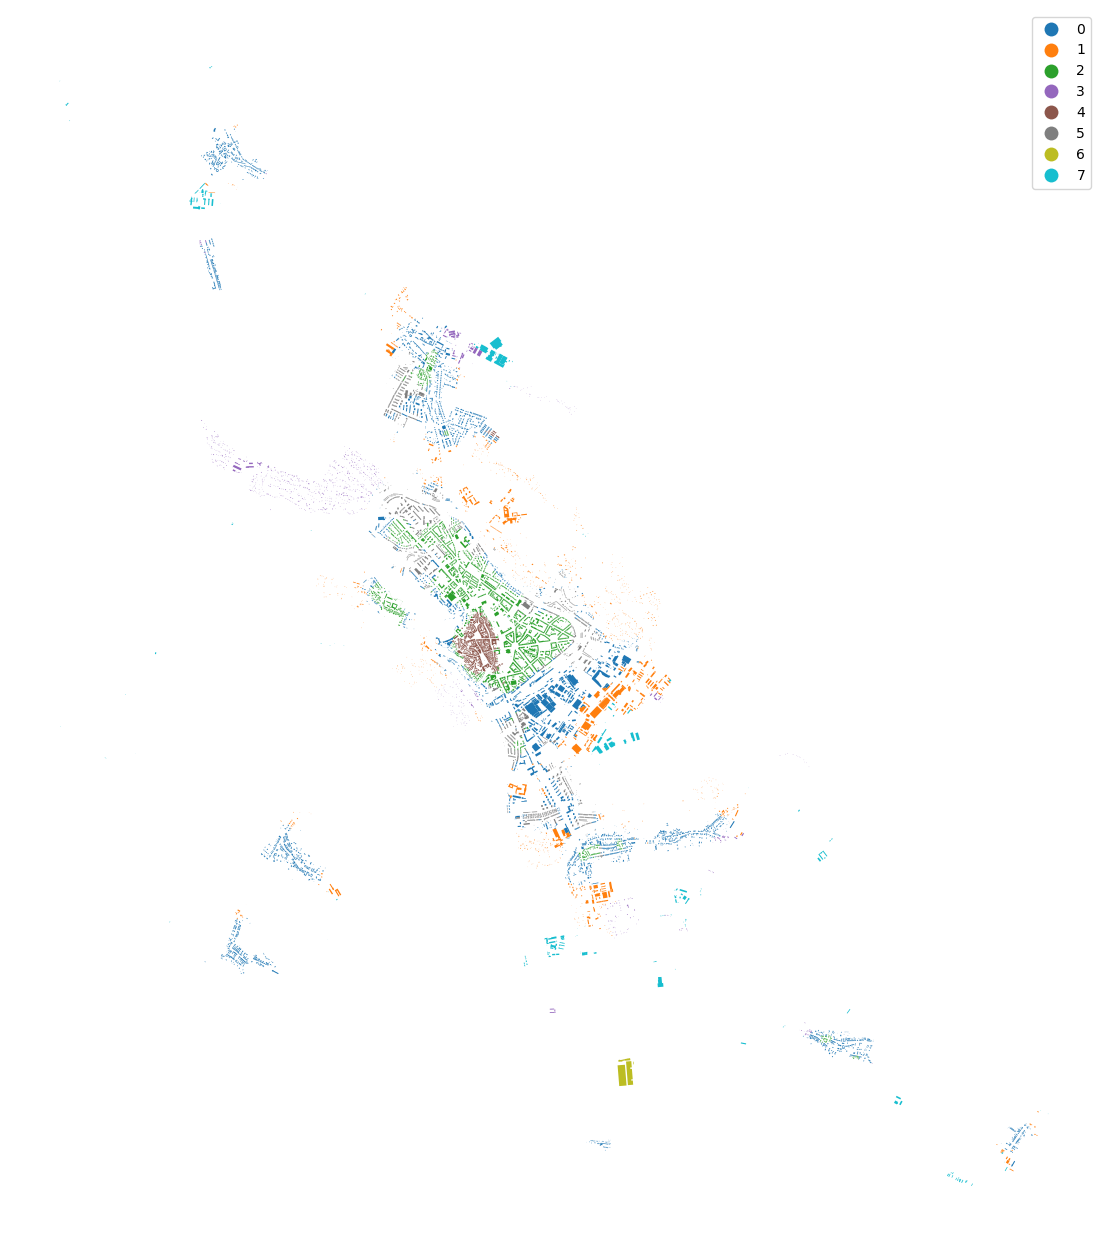

In [41]:
merged["cluster"] = cgram.labels[8].values
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")
urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True).set_axis_off()

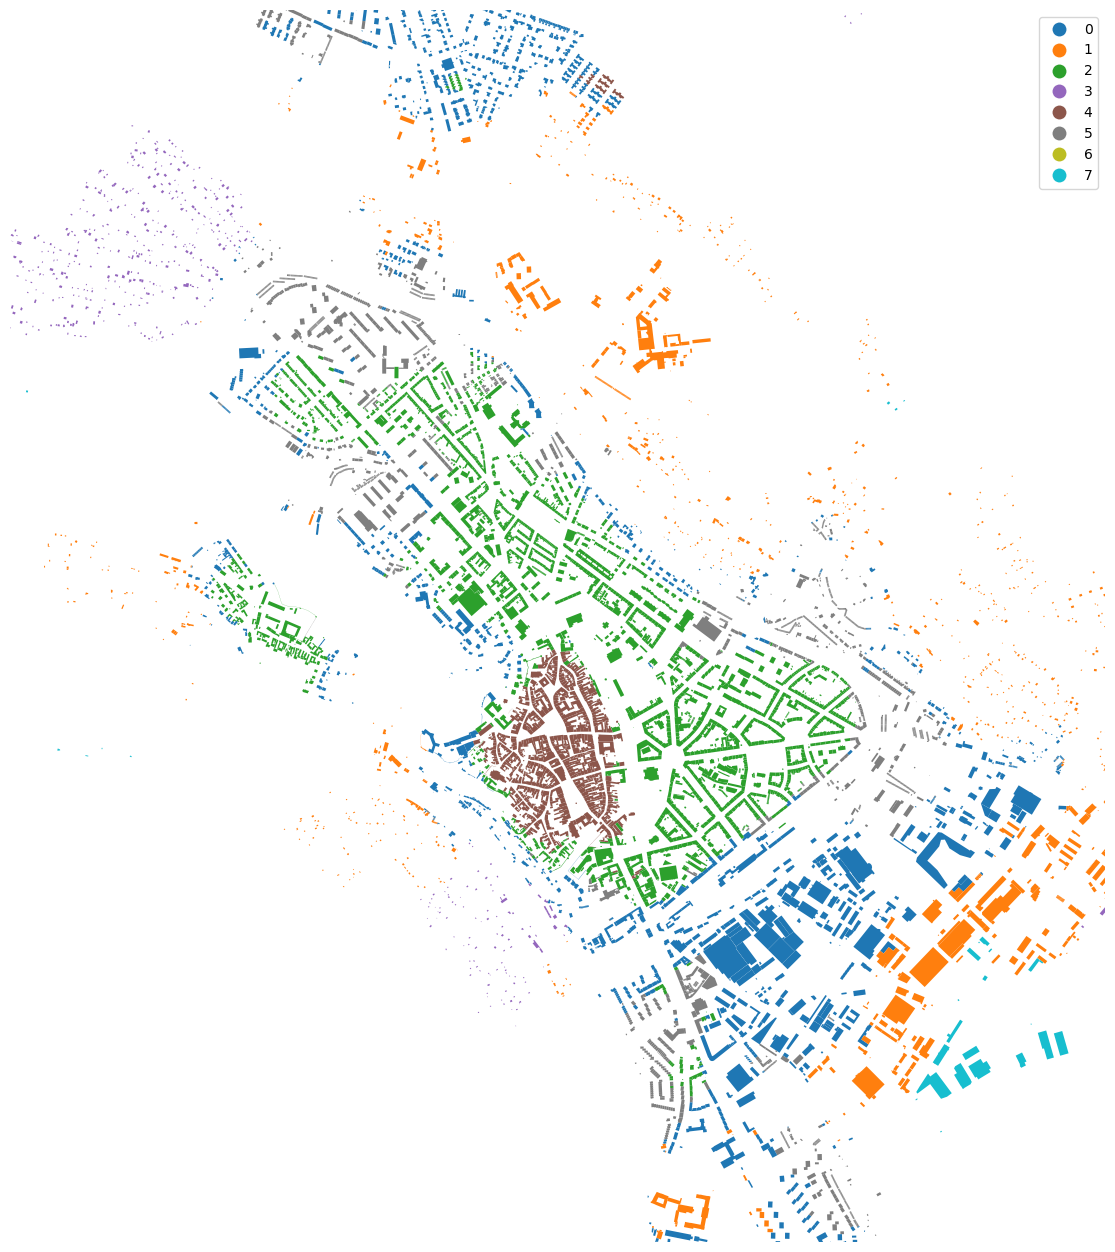

In [42]:
ax = urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()